# IS424: Data Mining & Biz Analytics
## Team: G3T3
### Project: Predicting Loan Default based on Customer Profile
### RandomForests
---

# 1. Setting up the notebook

### Import libraries

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, fbeta_score, accuracy_score, roc_auc_score

### Import dataset

In [10]:
df = pd.read_csv("../dataset/loanprediction.csv")
df.drop("Id", axis=1, inplace=True)

In [11]:
df.columns = ["income", "age", "experience", "marital_status", "house_ownership", "car_ownership", "profession", "city", "state", "current_job_years", "current_house_years", "risk_flag"]

In [12]:
numerical = list(df.describe().columns)[:-1]
categorical = [i for i in df.columns if i not in numerical and i != "risk_flag"]

### Splitting the data into train and test splits

In [13]:
x = df.drop("risk_flag", axis=1)
y = df["risk_flag"]

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 2021)

# 2. Feature Engineering

In [15]:
def feature_engineering(df_x, df_y):
    
    # Label encoding categorical columns with 2 types of categories
    x = df_x.copy()
    label_enc = LabelEncoder()
    x["marital_status"] = label_enc.fit_transform(x["marital_status"])
    x["car_ownership"] = label_enc.fit_transform(x["car_ownership"])
    
    # One Hot Encoding house_ownership column & Combining back to dataframe
    onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    
    house_ownership_values = onehot_encoder.fit_transform( x[['house_ownership']] )
    house_ownership_labels = np.array(["norent_noown", "owned", "rented"]).ravel()
    house_ownership_df = pd.DataFrame(house_ownership_values, columns=house_ownership_labels)

    x.reset_index(drop=True, inplace=True)
    house_ownership_df.reset_index(drop=True, inplace=True)
    x = pd.concat([ x, house_ownership_df], axis=1)
    
    x.drop("house_ownership", axis=1, inplace=True)
    
    # Target Encoding the high cardinality categorical columns: profession, city, state
    profession_target_enc = TargetEncoder()
    x["profession_encoded"] = profession_target_enc.fit_transform(x["profession"], df_y)
    city_target_enc = TargetEncoder()
    x["city_encoded"] = city_target_enc.fit_transform(x["city"], df_y)
    state_target_enc = TargetEncoder()
    x["state_encoded"] = state_target_enc.fit_transform(x["state"], df_y)
    x.drop("profession", axis=1, inplace=True)
    x.drop("city", axis=1, inplace=True)
    x.drop("state", axis=1, inplace=True)
    return x

x_train = feature_engineering(x_train, y_train)
x_test = feature_engineering(x_test, y_test)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


# 3. Feature Selection
## 3.1 Decision Tree
---

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

[Text(232.5, 377.5, 'experience <= 2.5\ngini = 0.216\nsamples = 201600\nvalue = [176803, 24797]'),
 Text(116.25, 226.5, 'age <= 31.5\ngini = 0.265\nsamples = 26977\nvalue = [22739, 4238]'),
 Text(58.125, 75.5, 'gini = 0.327\nsamples = 5180\nvalue = [4113, 1067]'),
 Text(174.375, 75.5, 'gini = 0.249\nsamples = 21797\nvalue = [18626, 3171]'),
 Text(348.75, 226.5, 'age <= 33.5\ngini = 0.208\nsamples = 174623\nvalue = [154064, 20559]'),
 Text(290.625, 75.5, 'gini = 0.233\nsamples = 39199\nvalue = [33916, 5283]'),
 Text(406.875, 75.5, 'gini = 0.2\nsamples = 135424\nvalue = [120148, 15276]')]

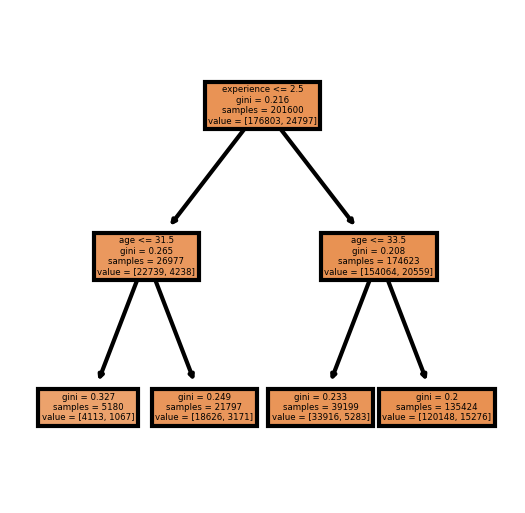

In [17]:
clf = DecisionTreeClassifier(max_depth=2, random_state=2021)
clf.fit(x_train, y_train)

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (2,2), dpi=300)
tree.plot_tree(clf,
               feature_names = x_train.columns,
               filled = True)

## 3.2 RandomForestClassifier
---

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=2021)
rf_clf.fit(x_train, y_train.values.ravel() )

RandomForestClassifier(random_state=2021)

In [19]:
def retrieve_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data = {'feature_name':feature_names,'feature_importance':feature_importance}
    feature_importance_df = pd.DataFrame(data)

    feature_importance_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    return feature_importance_df.reset_index(drop=True)


feat_impt_df = retrieve_feature_importance(rf_clf.feature_importances_, x_train.columns)
feat_impt_df

,feature_name,feature_importance
0,income,0.185485
1,city_encoded,0.159253
2,profession_encoded,0.144572
3,age,0.141265
4,state_encoded,0.104522
5,experience,0.085605
6,current_job_years,0.076982
7,current_house_years,0.064581
8,car_ownership,0.015491
9,marital_status,0.010865


## 3.3 XGBoost
---

In [26]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False,
                    random_state=2021)
                    
xgb.fit(x_train, y_train)

[22:19:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              random_state=2021, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [28]:
feat_impt_df = retrieve_feature_importance(xgb.feature_importances_, x_train.columns)
feat_impt_df

,feature_name,feature_importance
0,income,0.097845
1,city_encoded,0.088775
2,rented,0.086748
3,car_ownership,0.083332
4,age,0.083198
5,state_encoded,0.083187
6,profession_encoded,0.081845
7,current_job_years,0.079102
8,experience,0.078977
9,current_house_years,0.074698


## 3.4 Lasso Regression
---

In [32]:
from sklearn.linear_model import Lasso

alpha_param = [1e-4, 1e-3, 1e-2, 1e-1, 1]

for alpha in alpha_param:
    lasso = Lasso(alpha=alpha)
    lasso.fit(x_train, y_train)

    importance = np.abs( lasso.coef_ )

    feat_impt_df = retrieve_feature_importance(importance, x_train.columns)
    feat_impt_df.index.rename('alpha='+str(alpha), inplace=True) 
    print( feat_impt_df )
    print()

                     feature_name  feature_importance
alpha=0.0001                                         
0                          rented        2.834742e-02
1                  marital_status        2.123702e-02
2                   car_ownership        1.564969e-02
3                           owned        5.941071e-03
4                      experience        2.235591e-03
5               current_job_years        8.618301e-04
6             current_house_years        5.383408e-04
7                             age        3.892070e-04
8                          income        2.928949e-10
9                    norent_noown        0.000000e+00
10             profession_encoded        0.000000e+00
11                   city_encoded        0.000000e+00
12                  state_encoded        0.000000e+00

                    feature_name  feature_importance
alpha=0.001                                         
0                         rented        1.961749e-02
1                  car_ownersh

# 4. Feature Scaling

In [ ]:
def feature_scaling(df_x):
    min_max_scaler = MinMaxScaler()
    x[numerical] = min_max_scaler.fit_transform(x[numerical])
    return x

x_train = feature_scaling(x_train)
x_test = feature_scaling(x_test)

# 5. Model Train

In [ ]:
def run_variation_model(x_train, y_train, x_test, y_test, variation):
    if "pca" in variation:
        pca = PCA(0.9, random_state=2021)
        x_train = pca.fit_transform(x_train)
        x_test = pca.fit_transform(x_test)
        
    if "chi_square" in variation:
        chi_scores = chi2(x_train, y_train)
        p_values = pd.Series(chi_scores[1], index = x_train.columns)
        p_values.sort_values(ascending = False , inplace = True)
        p_values.plot.bar()
        x_train = x_train.drop(["profession_encoded", "state_encoded", "city_encoded", "income"], axis=1)
        x_test = x_test.drop(["profession_encoded", "state_encoded", "city_encoded", "income"], axis=1)
        
    if "smote" in variation:
        oversampler = SMOTE(random_state=2021)
        x_train, y_train = oversampler.fit_resample(x_train, y_train)
    
    rf_clf = RandomForestClassifier(random_state=2021)
    rf_clf.fit(x_train, y_train)
    y_pred = rf_clf.predict(x_test)
    
    print(f"-------------------------TEST SCORES for {variation}-----------------------")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"F2-Score: {fbeta_score(y_test, y_pred, beta=2)}")
    print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
    print(f"AUC Score: {roc_auc_score(y_test, y_pred)}")
    print()

In [ ]:
variations = ["base",
              "smote",
              "chi_square",
              "pca",
              "smote, chi_square",
              "smote, pca"]

for variation in variations:
    run_variation_model(x_train, y_train, x_test, y_test, variation)